# Multiclass GALE - Spirals Dataset with LIME

In [1]:
import numpy as np
np.random.seed(1000)

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier

from lime.lime_tabular import LimeTabularExplainer

from gale import create_mapper, mapper_to_networkx
from metricmapper.metricmapper import *

## 1. Generate data

In [2]:
def generate_spirals(n_samples=400, dimensions=2, n_classes=3, radius=1, theta=0.2):

    X = np.zeros((n_samples*n_classes, dimensions))
    y = np.zeros(n_samples*n_classes)

    for i in range(n_classes):
      ix = range(n_samples*i, n_samples*(i+1))
      r = np.linspace(0.0, radius, n_samples)
      t = np.linspace(i*4,(i+1)*4,n_samples) + np.random.randn(n_samples)*theta
      X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
      y[ix] = i

    return X, y

In [3]:
X, y = generate_spirals(n_samples=1000, theta=0.4)
df = pd.DataFrame(X, columns=['x'+str(i+1) for i in range(X.shape[1])])
df['y'] = y

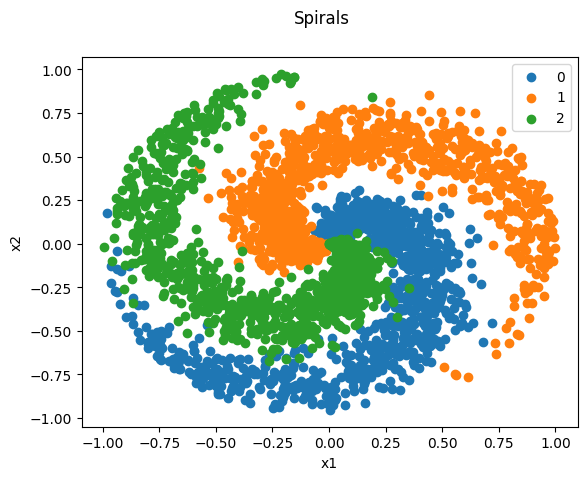

In [4]:
fig = plt.figure()
fig.suptitle('Spirals')

grouped_dataset = df.groupby('y')
labels = ['0', '1', '2']

for i, group in grouped_dataset:
    plt.scatter(group['x1'], group['x2'], label=labels[int(i)])

plt.ylabel('x2')
plt.xlabel('x1')
plt.legend()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

## 2. Train model

In [6]:
mlp = MLPClassifier(hidden_layer_sizes=(64, 64), batch_size=16, random_state=2020, max_iter=1000)
mlp.fit(X_train, y_train)

predictions = mlp.predict_proba(X_test)

print(classification_report(y_test, mlp.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95       300
         1.0       0.99      0.98      0.98       300
         2.0       0.94      0.99      0.96       300

    accuracy                           0.97       900
   macro avg       0.97      0.97      0.97       900
weighted avg       0.97      0.97      0.97       900



## 3. Generate explanations

In [7]:
def run_lime(X, model, num_classes, num_features=4, num_samples=100):
    labels = [i for i in range(num_classes)]
    explainer = LimeTabularExplainer(X, discretize_continuous=False, random_state=2020)
    lime_exp = [[] for i in range(num_classes)]
    for x in X:
        exp = explainer.explain_instance(x, model.predict_proba, num_features=num_features, 
                                         num_samples=num_samples, labels=labels)
        for i in range(num_classes):
            tmp = [0 for i in range(X.shape[1])]
            for e in exp.as_list(label=i):
                tmp[int(e[0])] = e[1]
            lime_exp[i].append(tmp)
    lime_exp = np.array(lime_exp)
    return lime_exp

Get explanations for each test sample and class:

In [8]:
lime_exp = run_lime(X_test, mlp, num_classes=3)

Get explanations for the classified class:

In [9]:
lime_exp_class = []
pred_class = mlp.predict(X_test)

for i in range(X_test.shape[0]):
    pred = int(pred_class[i])
    lime_exp_class.append(lime_exp[pred,i])

lime_exp_class = np.array(lime_exp_class)

## 4. Mapper for each class

Get distance threshold parameter for the feature space and the explanation space of every feature:

In [10]:
# Get distance threshold parameter
delta_feat = estimate_scale(X_test, 100)
print(f"Delta features: {delta_feat}")

delta_lime = []
for i in range(lime_exp.shape[0]):
    delta_lime.append(estimate_scale(lime_exp[i,:], 100))

print(f"Deltas lime: {delta_lime}")

resolution = 5
gain = 0.5

Delta features: 0.2227903269339146
Deltas lime: [0.1121919306380886, 0.11562811609376555, 0.10901952674194851]


Generate mapper of the feature space using the predicted probability of each class as the lens function. 


The node color indicates the average predicted probability of the class for the node, ranging from blue (low values) to pink (mid values) to yellow (high values).

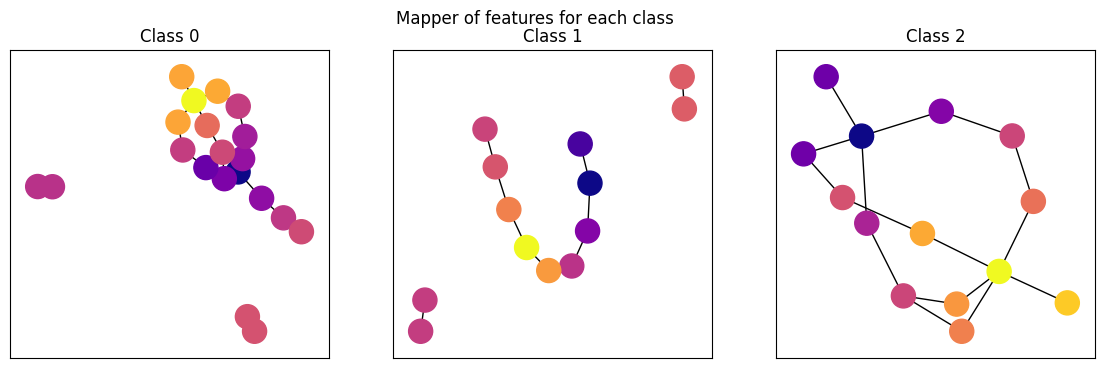

In [11]:
mapper_classes = []

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Mapper of features for each class')

for i in range(3):
    mapper = create_mapper(X_test, predictions[:,i], resolution=resolution, gain=gain, dist_thresh=delta_feat/(X_test.max() - X_test.min()))
    mapper_classes.append(mapper)
    G = mapper_to_networkx(mapper)
    colors = list(nx.get_node_attributes(G, "avg_pred").values())
    nx.draw_networkx(G, ax=axs[i], with_labels=False, node_color=colors, cmap=plt.cm.plasma)
    axs[i].set_title('Class '+str(i))

Generate mapper the explanation space for each feature using the corresponding predicted probability as the lens function. 

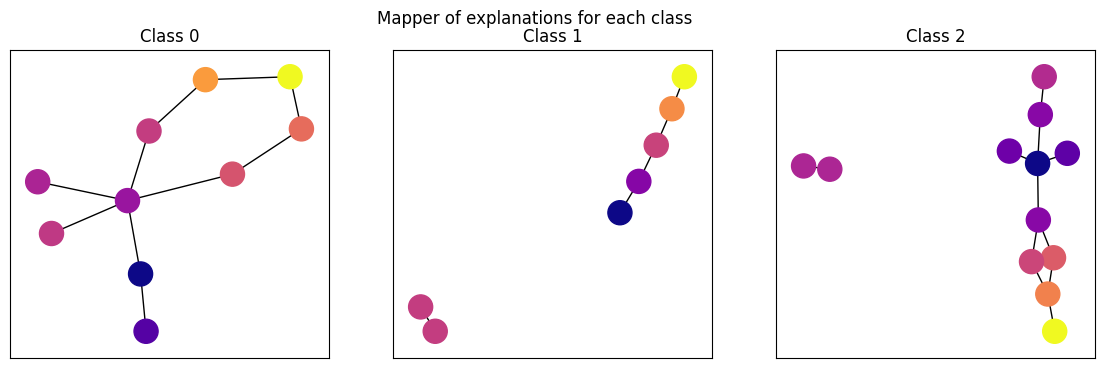

In [12]:
mapper_classes = []

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Mapper of explanations for each class')

for i in range(3):
    mapper = create_mapper(lime_exp[i,:], predictions[:,i], resolution=resolution, gain=gain, 
                            dist_thresh=delta_lime[i]/(lime_exp[i,:].max() - lime_exp[i,:].min()))
    mapper_classes.append(mapper)
    G = mapper_to_networkx(mapper)
    colors = list(nx.get_node_attributes(G, "avg_pred").values())
    nx.draw_networkx(G, ax=axs[i], with_labels=False, node_color=colors, cmap=plt.cm.plasma)
    axs[i].set_title('Class '+str(i))

## 5. Mapper for all classes

In [13]:
def get_avg_pred(predictions, mapper):
    n_nodes = len(mapper.node_info_.keys())
    avg_pred = {'Class 0': {},
                'Class 1': {},
                'Class 2': {}}

    for k in mapper.node_info_.keys():
        index_k = mapper.node_info_[k]['indices']

        for c in range(3):
            avg_pred['Class '+str(c)][k] = np.mean(predictions[index_k,c])

    return avg_pred

def get_var_pred(predictions, mapper):
    n_nodes = len(mapper.node_info_.keys())
    var_pred = {}

    for k in mapper.node_info_.keys():
        index_k = mapper.node_info_[k]['indices']

        var_pred[k] = np.var(predictions[index_k,:])

    return var_pred

In [14]:
def plot_mapper_var_preds(mapper, predictions, suptitle='Mapper of explanations for predicted class'):

    G = mapper2networkx(mapper)
    pos = nx.kamada_kawai_layout(G)

    avg_pred = get_avg_pred(predictions, mapper)
    var_pred = get_var_pred(predictions, mapper)

    fig, axs = plt.subplots(1, 4, figsize=(16, 5))
    fig.suptitle(suptitle)

    for i in range(3):
        colors = list(avg_pred['Class '+str(i)].values())
        if i==0:
            cmap = 'Blues'
        elif i==1:
            cmap = 'Oranges'
        elif i==2:
            cmap = 'Greens'

        d = nx.draw_networkx(G, with_labels=False, pos=pos, ax=axs[i+1],
                        node_color=colors, cmap=cmap, edgecolors='gray', linewidths=0.3,
                        node_size=100, edge_color="gray", width=0.3)
        vmin = min(colors)
        vmax = max(colors)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
        fig.colorbar(sm, ax=axs[i+1], location='bottom')

        axs[i+1].set_title('Prediction for class '+str(i))

    colors = list(var_pred.values())
    cmap = plt.cm.plasma
    draw = nx.draw_networkx(G, with_labels=False, pos=pos, ax=axs[0],
                    node_color=colors, cmap=cmap, node_size=100, edgecolors='gray', linewidths=0.3,
                    edge_color="gray", width=0.3)

    vmin = min(colors)
    vmax = max(colors)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    fig.colorbar(sm, ax=axs[0], orientation="horizontal")

    axs[0].set_title('Variance of predictions')

    plt.tight_layout()
    plt.show()

Create the cover that will be used to generate the mappers:

In [15]:
resolution = 5
gain = 0.5

cover = HypercubeCover(cover_mode="implicit", 
                       bnds=np.array([[0.,1.],[0.,1.],[0.,1.]]), 
                       resolutions=np.array([resolution, resolution, resolution]), 
                       gains=np.array([gain, gain, gain]))

Generate mapper of the feature space using the three predicted probabilities as the lens function.

The node color indicates the variance of the predicted probability, ranging from blue (low values) to pink (mid values) to yellow (high values). This means that blue nodes are the most difficult to classify (the predicted probabilities are similar), while yellow nodes are the easiest to classify.

The mapper has 93 vertices.


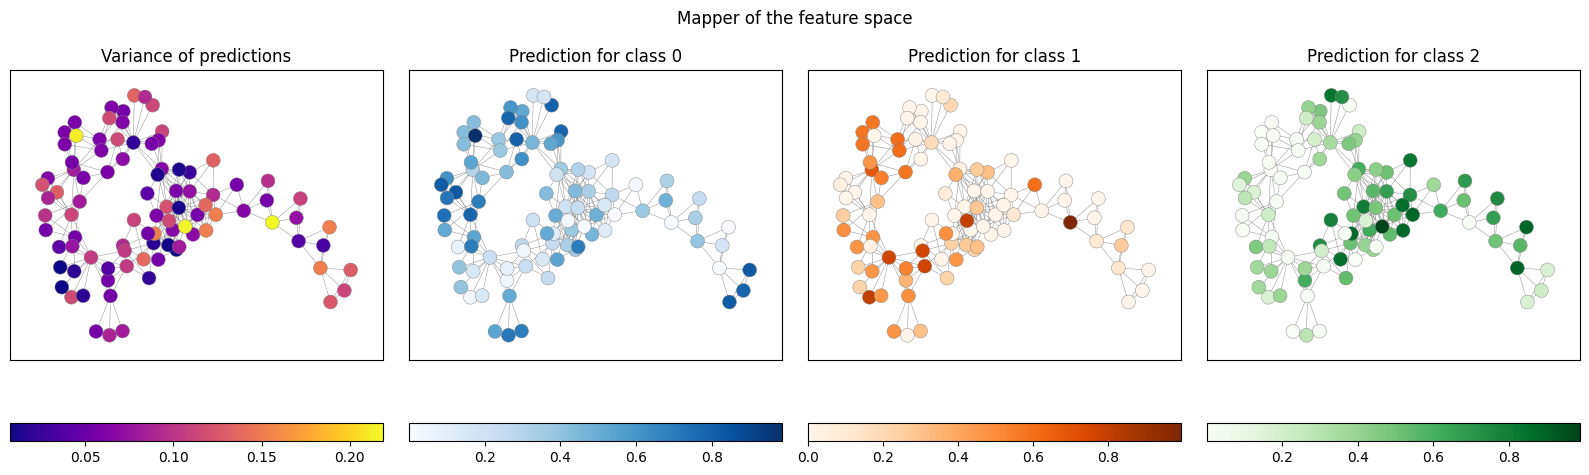

In [16]:
mapper = MetricMapperComplex(filters=predictions, colors=predictions, codomain="vectors", 
                            cover=cover,
                            clustering=AgglomerativeClustering(n_clusters=None, 
                                                               linkage="single", 
                                                               distance_threshold=delta_feat)
                            ).fit(X_test)

print(f"The mapper has {mapper.mapper_.num_vertices()} vertices.")

plot_mapper_var_preds(mapper, predictions, 'Mapper of the feature space')

Generate the mapper of the explanation space for each class using the predicted probability of all classes as lens function:

The mapper has 77 vertices.
The mapper has 70 vertices.
The mapper has 79 vertices.


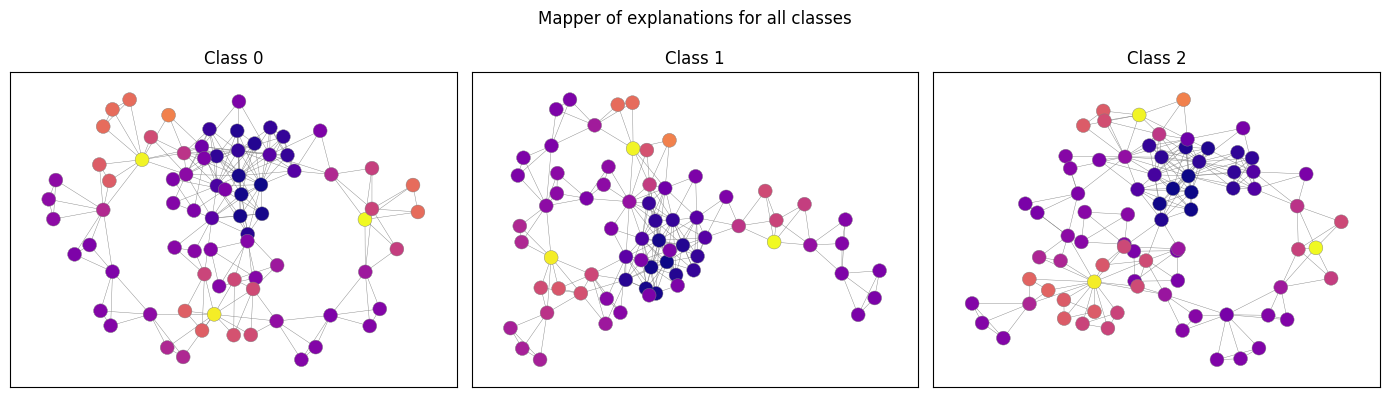

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Mapper of explanations for all classes')

for i in range(3):
    mapper = MetricMapperComplex(filters=predictions, colors=predictions, codomain="vectors", 
                                cover=cover,
                                clustering=AgglomerativeClustering(n_clusters=None, 
                                                                linkage="single", 
                                                                distance_threshold=delta_lime[i])
                                ).fit(lime_exp[i,:])

    print(f"The mapper has {mapper.mapper_.num_vertices()} vertices.")

    G = mapper2networkx(mapper)
    nx.draw_networkx(G, with_labels=False, pos=nx.kamada_kawai_layout(G), 
                    node_color=[np.var(mapper.node_info_[name]["colors"]) for name in G.nodes()],
                    cmap=plt.cm.plasma, ax=axs[i], node_size=100, edgecolors='gray', linewidths=0.3,
                 edge_color="gray", width=0.3)
    axs[i].set_title('Class '+str(i))

plt.tight_layout()
plt.show()

Now, we generate the mapper of the explanations of the predicted class:

The mapper has 77 vertices.


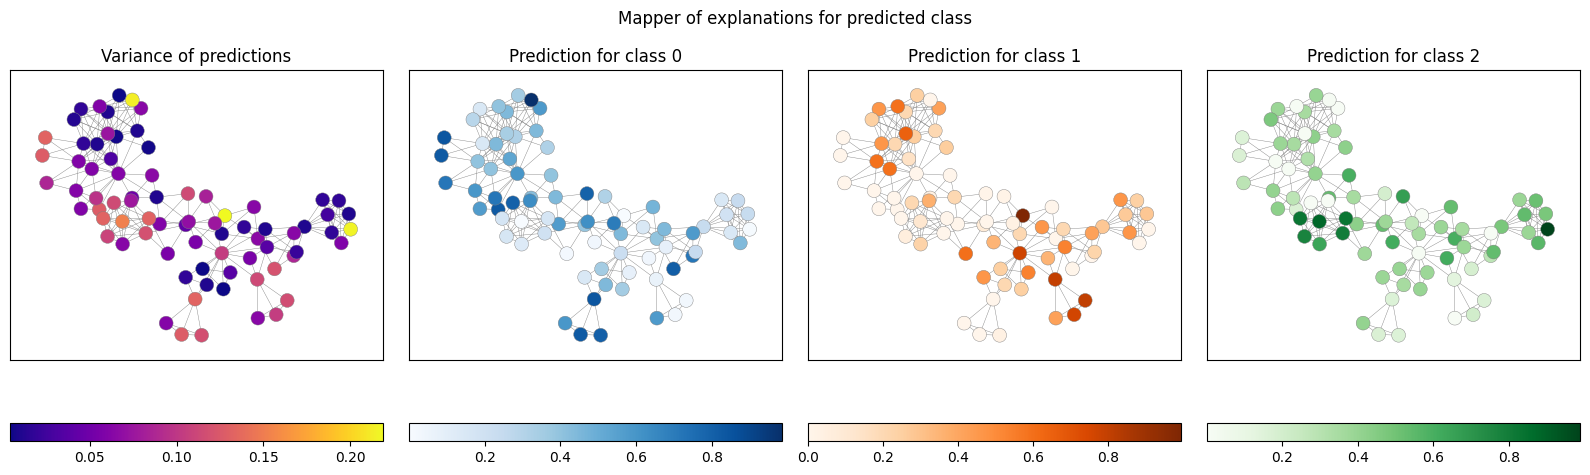

In [18]:
delta_lime_class = estimate_scale(lime_exp_class, 100)

mapper = MetricMapperComplex(filters=predictions, colors=predictions, codomain="vectors", 
                            cover=cover,
                            clustering=AgglomerativeClustering(n_clusters=None, 
                                                               linkage="single", 
                                                               distance_threshold=delta_lime_class)
                            ).fit(lime_exp_class)

print(f"The mapper has {mapper.mapper_.num_vertices()} vertices.")

plot_mapper_var_preds(mapper, predictions)